# Imports

In [1]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, io, pickle, random
 
import tensorflow as tf
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.mixed_precision import experimental as mixed_precision

## Seed 

In [3]:
# seed everything
SEED = 256
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Hardware config

In [4]:
# Detect hardware, set appropriate distribution strategy (GPU/TPU)
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        
        # set half precision policy
        # Mixed precision is the use of both 16-bit and 32-bit floating-point types
        # in a model during training to make it run faster and use less memory.
        mixed_precision.set_policy('mixed_bfloat16' if TPU else 'float32')
        print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
        print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')
        
        # enable XLA optmizations
        tf.config.optimizer.set_jit(True)
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

TPU=True
strategy = auto_select_accelerator()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU: grpc://10.0.0.2:8470
Compute dtype: bfloat16
Variable dtype: float32
Running on 8 replicas
REPLICAS: 8


In [5]:
DEBUG = False

# image resolution
IMG_HEIGHT = 300
IMG_WIDTH = 480
N_CHANNELS = 3
# maximum InChI length is 200 to prevent too much padding
MAX_INCHI_LEN = 200

# batch sizes
BATCH_SIZE_BASE = 5 if DEBUG else (18 if TPU else 24)

BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS
BATCH_SIZE_DEBUG = 2

# target data type, bfloat16 when using TPU to improve throughput
TARGET_DTYPE = tf.bfloat16 if TPU else tf.float32
 # minimal memory usage of labels
LABEL_DTYPE= tf.uint8

# 100K validation images are used
VAL_SIZE = int(1e3) if DEBUG else int(100e3)
VAL_STEPS = VAL_SIZE // BATCH_SIZE


IMAGE_CH3 = tf.constant([0.0, 0.0, 0.0], dtype=tf.float32)

# Dataset
* voc dict

In [6]:
# dictionary to translate a character to the integer encoding
with open('../input/bms300x480-image-data/vocabulary_to_int.pkl', 'rb') as p:
    vocabulary_to_int= pickle.load(p)
    
# dictionary to decode an integer encoded character back to the character
with open('../input/bms300x480-image-data/int_to_vocabulary.pkl', 'rb') as p:
    int_to_vocabulary= pickle.load(p)

In [7]:
# configure model
VOCAB_SIZE = len(vocabulary_to_int.values())
SEQ_LEN_OUT = MAX_INCHI_LEN
DECODER_DIM = 512
ATTENTION_UNITS = 512

print(f'VOCAB_SIZE: {VOCAB_SIZE}')

VOCAB_SIZE: 41


* decode TFRecord

In [8]:
def decode_tfrecord(record_bytes):
    feature= tf.io.parse_single_example(record_bytes,{
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64)
    })
    # decode the PNG and explicitly reshape to image size (required on TPU)
    image = tf.io.decode_png(feature['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    # normalize according to ImageNet mean and std
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGE_CH3)
    
    if TPU: # if running on TPU image needs to be cast to bfloat16
        image = tf.cast(image, TARGET_DTYPE)
    
    InChI = tf.reshape(feature['InChI'], [MAX_INCHI_LEN])
    InChI = tf.cast(InChI, LABEL_DTYPE)
    #InChI= tf.one_hot(InChI, depth= 41)
    
    return (1.0-image), InChI

# TPU-Data Pipeline

In [9]:
DATASET_NAME= 'bms300x480-image-data'
GCS_DS_PATH= KaggleDatasets().get_gcs_path(DATASET_NAME) if TPU else '../input/bmstfrecord-data'
GCS_DS_PATH

'gs://kds-09f49a72bf080607deaed5b8ae6ca069818737e04bbbe3d2341a0f53'

In [10]:
def get_train_dataset(bs= BATCH_SIZE):
    #A tf.data.Options object can be, for instance, used to control which static optimizations to apply
    #to the input pipeline graph or whether to use performance modeling to dynamically tune the parallelism
    #of operations such as tf.data.Dataset.map or tf.data.Dataset.interleave.
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/train/*.tfrecords')
    AUTO= tf.data.experimental.AUTOTUNE
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    
    train_dataset = train_dataset.with_options(ignore_order)
    train_dataset = train_dataset.prefetch(AUTO) # optimize automatically
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)  # optimize automatically
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
    #train_dataset = train_dataset.prefetch(1) # just 1 prefetched batch is needed
    
    return train_dataset

train_dataset = get_train_dataset()

In [11]:
def get_val_dataset(bs=BATCH_SIZE):
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{GCS_DS_PATH}/val/*.tfrecords')
    AUTO= tf.data.experimental.AUTOTUNE
    val_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    val_dataset = val_dataset.prefetch(AUTO)
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.prefetch(1)
    
    return val_dataset

val_dataset = get_val_dataset()

In [12]:
#load one iter sample
imgs, lbls = next(iter(train_dataset))
print(f'imgs.shape: {imgs.shape}, lbls.shape: {lbls.shape}')

imgs.shape: (144, 300, 480, 3), lbls.shape: (144, 200)


# Encoder-Decoder Model Config

In [13]:
class Encoderv1(tf.keras.Model):
    """Encoderv1"""
    def __init__(self):
        super(Encoderv1, self).__init__()
        self.fea_ext = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', drop_connect_rate=0.3)
        global ENCODER_DIM
        ENCODER_DIM = self.fea_ext.layers[-1].output_shape[-1] 
        self.reshape = tf.keras.layers.Reshape([-1, ENCODER_DIM], name='reshape_featuere_maps')
        self.permuate = tf.keras.layers.Permute([2, 1], name='permutate_features_last')
    def call(self, x, training):
        x = self.fea_ext(x, training=training)
        x = self.reshape(x, training=training)
        x = self.permuate(x, training=training)
        return x

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    """BahdanauAttention"""
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units, name='hidden_to_attention_units')
        self.W2= tf.keras.layers.Dense(units, name='encoder_to_attention_units')
        self.V= tf.keras.layers.Dense(1, name='score_to_alpha')
    def call(self, h, encoder_res, training):
        # dense hidden state to attention units size and expand dimension
        hidden_with_time_axis = tf.expand_dims(h, 1)
        hidden_with_time_axis = self.W1(hidden_with_time_axis, training=training)
        # dense features to units size
        encoder_res_dense = self.W2(encoder_res, training=training)
        # add vectors
        score = tf.math.tanh(hidden_with_time_axis + encoder_res_dense)
        score = self.V(score, training=training)
        # create alpha vector size (bs, layers)        
        attention_weights = tf.nn.softmax(score, axis=1)
        # create attention weights (bs, layers)
        context_vector = encoder_res * attention_weights #  tf.expand_dims(attention_weights, axis=2)
        context_vector = tf.reduce_sum(context_vector  , axis=2)
        return context_vector, attention_weights

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, attention_units, encoder_dim, decoder_dim):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attention_units = attention_units
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        # LSTM hidden and carry state initialization
        self.init_h = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_hidden_init')
        self.init_c = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_inp_act_init')
        # The LSTM cell
        self.lstm_cell = tf.keras.layers.LSTMCell(decoder_dim, name='lstm_char_predictor')
        # dropout before prediction
        self.drop = tf.keras.layers.Dropout(0.3, name='prediction_dropout')
        # fully connected prediction layer
        self.fcn = tf.keras.layers.Dense(units=vocab_size, input_shape=[decoder_dim], activation='softmax', dtype=tf.float32, name='lstm_output_to_char_probs')
        # character embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, decoder_dim)

        # used for attention
        self.attention = BahdanauAttention(self.attention_units)
    def call(self, char, h, c, enc_output, training):
        
        # embed previous character
        char = self.embedding(char, training=training)
        char = tf.squeeze(char, axis=1)
        #print('------', char.shape)
        # get attention alpha and context vector
        context, _ = self.attention(h, enc_output, training=training)

        # concat context and char to create lstm input
        lstm_input = tf.concat((context, char), axis=-1)
        
        # LSTM call, get new h, c
        _, (h_new, c_new) = self.lstm_cell(lstm_input, (h, c), training=training)
        
        # compute predictions with dropout
        output = self.drop(h_new, training=training)
        output = self.fcn(output, training=training)

        return output, h_new, c_new
    def init_hidden_state(self, encoder_out, training):
        mean_encoder_out = tf.math.reduce_mean(encoder_out, axis=1)
        h = self.init_h(mean_encoder_out, training=training)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out, training=training)
        return h, c

In [16]:
# Example enoder output
with tf.device('/CPU:0'):
    encoder_ex = Encoderv1()
    encoder_res = encoder_ex(imgs[:2])
encoder_ex.summary()
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(encoder_res.shape))

43941888/43941136 [==============================] - 0s 0us/step
Model: "encoderv1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
reshape_featuere_maps (Resha multiple                  0         
_________________________________________________________________
permutate_features_last (Per multiple                  0         
Total params: 10,783,535
Trainable params: 10,696,232
Non-trainable params: 87,303
_________________________________________________________________
Encoder output shape: (batch size, sequence length, units) (2, 1536, 135)


In [17]:
with tf.device('/CPU:0'):
    decoder_ex = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM)
    h, c = decoder_ex.init_hidden_state(encoder_res, training=False)
    preds, h, c = decoder_ex(tf.random.uniform((2, 1)), h, c, encoder_res)

decoder_ex.summary()
print ('Decoder output shape: (batch_size, vocab size) {}'.format(preds.shape))

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_res_to_hidden_init ( multiple                  69632     
_________________________________________________________________
encoder_res_to_inp_act_init  multiple                  69632     
_________________________________________________________________
lstm_char_predictor (LSTMCel multiple                  5244928   
_________________________________________________________________
prediction_dropout (Dropout) multiple                  0         
_________________________________________________________________
lstm_output_to_char_probs (D multiple                  21033     
_________________________________________________________________
embedding (Embedding)        multiple                  20992     
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  3328

In [18]:
# The start/end/pad tokens will be removed from the string when computing the Levenshtein distance
START_TOKEN = tf.constant(vocabulary_to_int.get('<start>'), dtype=tf.int64)
END_TOKEN = tf.constant(vocabulary_to_int.get('<end>'), dtype=tf.int64)
PAD_TOKEN = tf.constant(vocabulary_to_int.get('<pad>'), dtype=tf.int64)

# Custom TPU Training

In [19]:
# Training configuration

base_lr= 0.001
final_lr= 1e-8
EPOCHS = 28
TRAIN_STEPS = 3000
VERBOSE_FREQ = 200
STEPS_PER_EPOCH = TRAIN_STEPS // VERBOSE_FREQ
TOTAL_STEPS = EPOCHS * TRAIN_STEPS
TOTAL_STEPS

84000

In [20]:
with strategy.scope():
    # Encoder
    encoder = Encoderv1()
    encoder.build(input_shape=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    encoder_res = encoder(imgs[:2], training=False)
    # Decoder
    decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM)
    h, c = decoder.init_hidden_state(encoder_res, training=False)
    preds, h, c = decoder(lbls[:2, :1], h, c, encoder_res, training=False)
    
    # Metrics
    train_loss = tf.keras.metrics.Sum()
    val_loss = tf.keras.metrics.Sum()

    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                            reduction=tf.keras.losses.Reduction.NONE)
    def loss_func(real, pred):
        per_example_loss= loss_object(real, pred)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE)
    
    optimizer = tf.keras.optimizers.Adam(base_lr)

In [21]:
@tf.function()
def distributed_train_step(dataset):
    # Step function
    def train_step(inp, targ):
        total_loss = 0.0
 
        with tf.GradientTape() as tape:
            enc_output = encoder(inp, training=True)
            h, c = decoder.init_hidden_state(enc_output, training=True)
            dec_input = tf.expand_dims(targ[:, 0], 1)
 
            for idx in range(1, SEQ_LEN_OUT):
                t = targ[:, idx]
                # passing enc_output to the decoder
                predictions, h, c = decoder(dec_input, h, c, enc_output, training=True)            
                # update loss and train metrics
                total_loss += loss_func(t, predictions)
                train_accuracy.update_state(t, predictions)
                # using NO teacher forcing
                dec_input= tf.expand_dims(tf.argmax(predictions, 1), 1)
                dec_input= tf.cast(dec_input, LABEL_DTYPE)
 
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(total_loss, variables)
        gradients, _ = tf.clip_by_global_norm(gradients, 8.0)
        optimizer.apply_gradients(zip(gradients, variables))
 
        batch_loss = total_loss / (SEQ_LEN_OUT - 1)
        train_loss.update_state(batch_loss)
    
    # reset metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    # perform VERBOSE_FREQ train steps
    for _ in tf.range(tf.convert_to_tensor(VERBOSE_FREQ)):
        strategy.run(train_step, args=next(dataset))

In [22]:
def validation_step(inp, targ):
    total_loss =0
    enc_output = encoder(inp, training=True)
    h, c = decoder.init_hidden_state(enc_output, training=True)
    dec_input= tf.expand_dims(targ[:, 0], 1)
    predictions_seq = tf.expand_dims(targ[:, 0], 1)

    for t in range(1, SEQ_LEN_OUT):
            # passing enc_output to the decoder
            predictions, h, c = decoder(dec_input, h, c, enc_output, training=False)
            total_loss += loss_func(targ[:, t], predictions)
            val_accuracy.update_state(targ[:, t], predictions)

            dec_input= tf.expand_dims(tf.argmax(predictions, 1), 1)
            dec_input= tf.cast(dec_input, LABEL_DTYPE)
            predictions_seq=  tf.concat([predictions_seq, dec_input], axis=1)
    batch_loss = total_loss / (SEQ_LEN_OUT - 1)
    val_loss.update_state(batch_loss)
    return targ, predictions_seq, batch_loss

In [23]:
@tf.function
def distributed_val_step(dataset):
    inp_val, targ_val = next(dataset)
    targ, predictions_seq, loss = strategy.run(validation_step, args=(inp_val, targ_val))
    return targ, predictions_seq, loss

In [24]:
def val_metrics(dataset):
    # reset metrics
    val_accuracy.reset_states()
    val_loss.reset_states()
    for step in range(VAL_STEPS):
        targ, predictions_seq, loss= distributed_val_step(dataset)
    return strategy.gather(targ, 0), strategy.gather(predictions_seq, 0), val_loss.result().numpy()/(VAL_STEPS)
    
def save_model(acc= False):
    if acc:
        encoder.save_weights('./encoder-imgnet-ACC.h5')
        decoder.save_weights('./decoder-imgnet-ACC.h5')
    else:
        encoder.save_weights('./encoder-imgnet-Loss.h5')
        decoder.save_weights('./decoder-imgnet-Loss.h5')
    
    
def lr_sch(step,  lr_init= 0.001, lr_final= final_lr, decay= EPOCHS):
    power = (step) // ((TOTAL_STEPS) / (decay + 1))
    decay_factor =  ((lr_init / lr_final) ** (1 / decay)) ** power
    lr = lr_init / decay_factor
    return lr
    
    
def log(final_val_loss):
    if final_val_loss > val_loss.result().numpy()/(VAL_STEPS):
        print('Val loss decreased from {:.3f} to {:.3f}. Lr {:.6}'.format(final_val_loss,
                          val_loss.result().numpy()/(VAL_STEPS), init_lr))
        save_model(acc= False)
        return val_loss.result().numpy()/(VAL_STEPS)
    else:
        return final_val_loss 
    
def log2(final_val_acc):
    if final_val_acc < val_accuracy.result().numpy():
        print('Val Acc increased from {:.3f} to {:.3f}. Lr {:.6}'.format(final_val_acc,
                          val_accuracy.result().numpy(), init_lr))
        save_model(acc= True)
        return val_accuracy.result().numpy()
    else:
        return final_val_acc 
    
    
def cosine_decay_with_warmup(global_step,
                                 learning_rate_base,
                                 total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0):
        if total_steps < warmup_steps:
            raise ValueError('total_steps must be larger or equal to '
                             'warmup_steps.')
        learning_rate = 0.5 * learning_rate_base * (
            1 + np.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) /
                float(total_steps - warmup_steps - hold_base_rate_steps)
                )
            )
        if hold_base_rate_steps > 0:
            learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                     learning_rate, learning_rate_base)
        if warmup_steps > 0:
            if learning_rate_base < warmup_learning_rate:
                raise ValueError('learning_rate_base must be larger or equal to '
                                 'warmup_learning_rate.')
            slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
            warmup_rate = slope * global_step + warmup_learning_rate
            learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                     learning_rate)
        return np.where(global_step > total_steps, 0.0, learning_rate)
    
    
def LR_schedule(step, change=True):
    lr= cosine_decay_with_warmup(step, 0.001, TOTAL_STEPS, 0.001)
    if change:
        optimizer.learning_rate.assign(lr)
    return lr

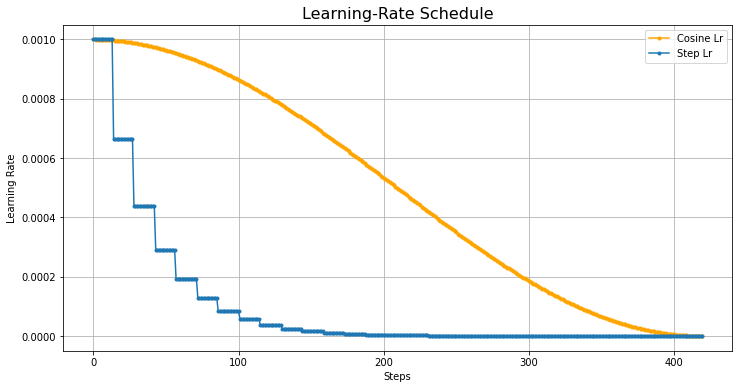

In [25]:
cosine_lr=[]; step_lr=[]
for epoch in range(EPOCHS):
    for step in range(1, STEPS_PER_EPOCH + 1):
        stepv2= epoch * TRAIN_STEPS + step * VERBOSE_FREQ - 1
        cosine_lr.append(LR_schedule(stepv2, change=False)); step_lr.append(lr_sch(stepv2))
        
plt.figure(figsize = (12, 6))
plt.xlabel("Steps"); plt.ylabel("Learning Rate")
plt.plot(cosine_lr, label = "Cosine Lr", color='orange', marker='.')
plt.plot(step_lr, label = "Step Lr", marker='.')
plt.title('Learning-Rate Schedule', size= 16)
plt.grid(True); plt.legend(); plt.show()

In [26]:
step_total = 0
final_val_loss= 1e2
final_val_acc= 0.4
erly_stop=0
T_loss, T_acc=[], []
V_loss, V_acc=[], []
init_lr= 0.001
 
for epoch in range(EPOCHS):
    print(f'********* EPOCH {epoch + 1} *****************')
    total_loss = 0
    # create distributed versions of dataset
    train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
    val_dist_dataset = iter(strategy.experimental_distribute_dataset(val_dataset))
    
    
    for step in range(1, STEPS_PER_EPOCH + 1):
        try:
            stepv2= epoch * TRAIN_STEPS + step * VERBOSE_FREQ - 1
            init_lr= LR_schedule(stepv2)
            # train step
            distributed_train_step(train_dist_dataset)
            total_loss+= (train_loss.result().numpy())
            T_loss.append(train_loss.result().numpy()/(VERBOSE_FREQ))
            T_acc.append(train_accuracy.result().numpy())

            if ((step*VERBOSE_FREQ)%1500==0) or ((step*VERBOSE_FREQ)== 1400):
                targ, predictions_seq, loss = val_metrics(val_dist_dataset)
                V_loss.append(loss)
                V_acc.append(val_accuracy.result().numpy())
                final_val_loss= log(final_val_loss)
                final_val_acc= log2(final_val_acc)
                print('Step {}/{} | Loss {:.4f} Acc. {:.4f} | Val_Loss {:.4f} Val_Acc {:.4} | LR {:.6}'.format(
                                     step*VERBOSE_FREQ, TRAIN_STEPS, train_loss.result().numpy()/(VERBOSE_FREQ),
                                     train_accuracy.result().numpy(), val_loss.result().numpy()/(VAL_STEPS),
                                     val_accuracy.result().numpy(), init_lr))

            else:
                print('Step {}/{} | Loss {:.4f} Acc. {:.4} | LR {:.6}'.format(step*VERBOSE_FREQ, TRAIN_STEPS,
                     train_loss.result().numpy()/(VERBOSE_FREQ), train_accuracy.result().numpy(), init_lr))
        except:
            print('Nan Value Encountered !!!')
    
    print(f'Epoch {epoch+1} Loss {round(total_loss/(TRAIN_STEPS), 3)}')

********* EPOCH 1 *****************
Step 200/3000 | Loss 1.6926 Acc. 0.5027 | LR 0.000999986
Step 400/3000 | Loss 1.4391 Acc. 0.5446 | LR 0.000999944
Step 600/3000 | Loss 1.3960 Acc. 0.5526 | LR 0.000999875
Step 800/3000 | Loss 1.3542 Acc. 0.5613 | LR 0.000999777
Step 1000/3000 | Loss 1.3255 Acc. 0.5676 | LR 0.000999651
Step 1200/3000 | Loss 1.2960 Acc. 0.5754 | LR 0.000999497
Val loss decreased from 100.000 to 1.263. Lr 0.000999316
Val Acc increased from 0.400 to 0.584. Lr 0.000999316
Step 1400/3000 | Loss 1.2820 Acc. 0.5793 | Val_Loss 1.2633 Val_Acc 0.5845 | LR 0.000999316
Step 1600/3000 | Loss 1.2603 Acc. 0.5856 | LR 0.000999106
Step 1800/3000 | Loss 1.2512 Acc. 0.5888 | LR 0.000998869
Step 2000/3000 | Loss 1.2284 Acc. 0.5947 | LR 0.000998603
Step 2200/3000 | Loss 1.2254 Acc. 0.597 | LR 0.00099831
Step 2400/3000 | Loss 1.2065 Acc. 0.6011 | LR 0.000997989
Step 2600/3000 | Loss 1.1942 Acc. 0.6053 | LR 0.00099764
Step 2800/3000 | Loss 1.1836 Acc. 0.6076 | LR 0.000997263
Val loss decrea

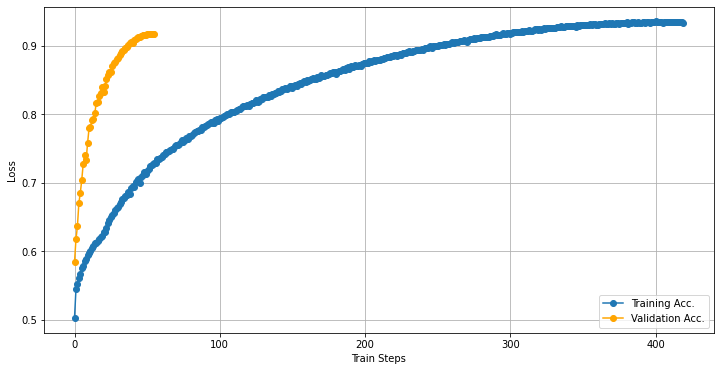

In [27]:
plt.figure(figsize = (12, 6))
plt.xlabel("Train Steps")
plt.ylabel("Loss")
plt.plot( T_acc, label = "Training Acc.", marker='o')
plt.plot( V_acc, label = "Validation Acc.", marker='o', color='orange')
plt.grid(True)
plt.legend()
plt.show()

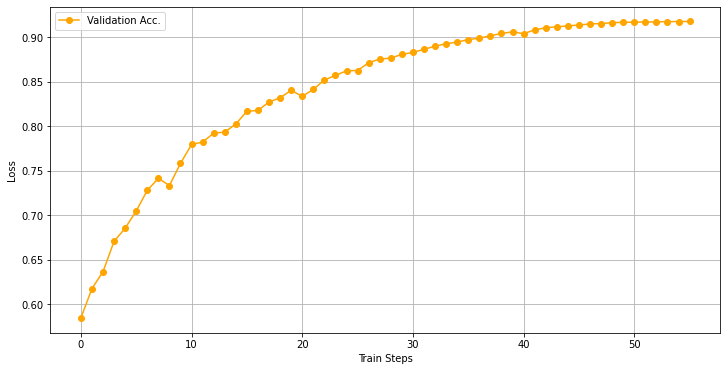

In [28]:
plt.figure(figsize = (12, 6))
plt.xlabel("Train Steps")
plt.ylabel("Loss")
plt.plot( V_acc, label = "Validation Acc.", marker='o', color='orange')
plt.grid(True)
plt.legend()
plt.show()

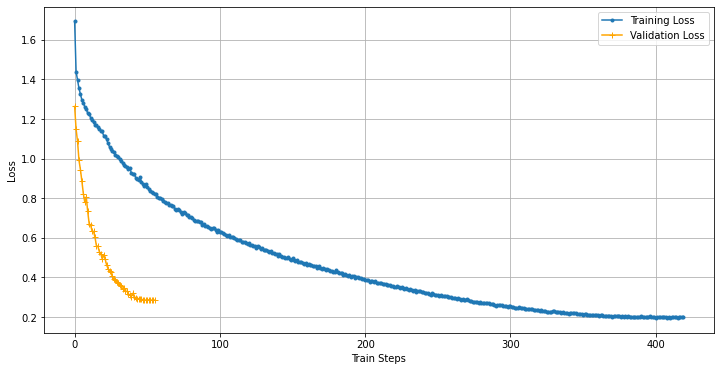

In [29]:
plt.figure(figsize = (12, 6))
plt.xlabel("Train Steps")
plt.ylabel("Loss")
plt.plot( T_loss, label = "Training Loss", marker='.')
plt.plot( V_loss, label = "Validation Loss", marker='+', color='orange')
plt.grid(True)
plt.legend()
plt.show()

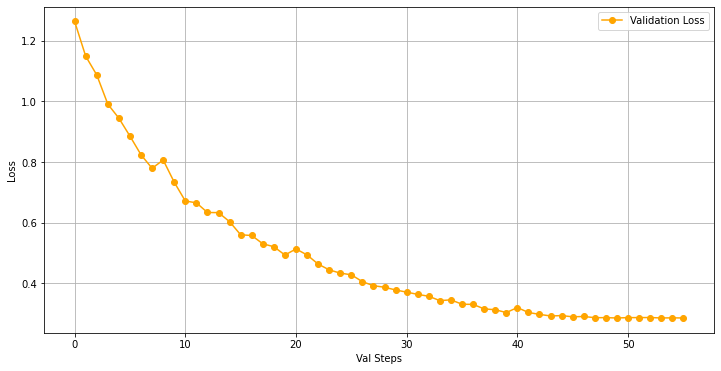

In [30]:
plt.figure(figsize = (12, 6))
plt.xlabel("Val Steps")
plt.ylabel("Loss")
plt.plot( V_loss, label = "Validation Loss", marker='o', color='orange')
plt.grid(True)
plt.legend()
plt.show()